In [1]:
import pandas as pd
import tensorflow as tf
import os
import matplotlib.pyplot as plt

In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

Device: grpc://10.0.0.2:8470
Number of replicas: 8
2.4.1


In [3]:
df = pd.read_csv('../input/chatbot-dataset-topical-chat/topical_chat.csv')
df.head()

,conversation_id,message,sentiment
0,1,Are you a fan of Google or Microsoft?,Curious to dive deeper
1,1,Both are excellent technology they are helpfu...,Curious to dive deeper
2,1,"I'm not a huge fan of Google, but I use it a...",Curious to dive deeper
3,1,Google provides online related services and p...,Curious to dive deeper
4,1,"Yeah, their services are good. I'm just not a...",Curious to dive deeper


In [4]:
df.conversation_id.astype(str).describe()

count     188378
unique      8628
top         2600
freq          53
Name: conversation_id, dtype: object

In [5]:
df.sentiment.unique()

array([' Curious to dive deeper', ' Happy', ' Neutral', ' Surprised',
       ' Disgusted', ' Sad', ' Fearful', ' Angry'], dtype=object)

In [6]:
import re
import string, os 
def process(text):
    text = text.lower().replace('\n', ' ').replace('-', ' ').replace(':', ' ').replace(',', '') \
          .replace('"', '').replace("...", ".").replace("..", ".").replace("!", ".").replace("?", " ?").replace(";", ".").replace(":", " ")

    #text = "".join(v for v in text if v not in string.punctuation).lower()
    #text = text.encode("utf8").decode("ascii",'ignore')

    text = " ".join(text.split())
    #text+="<eos>"
    return text


In [7]:
df.message = df.message.apply(process)

In [8]:
df.head()

,conversation_id,message,sentiment
0,1,are you a fan of google or microsoft ?,Curious to dive deeper
1,1,both are excellent technology they are helpful...,Curious to dive deeper
2,1,i'm not a huge fan of google but i use it a lo...,Curious to dive deeper
3,1,google provides online related services and pr...,Curious to dive deeper
4,1,yeah their services are good. i'm just not a f...,Curious to dive deeper


In [9]:
df.message[33]

'nice. do you like shakespeare ?'

In [10]:
# crudely selecting conversation IDs with shorter sentences
short_conversations_mask = df.message.str.contains("\?")
short_conversations_mask = short_conversations_mask
short_conversations = df.conversation_id[short_conversations_mask].astype(str).value_counts()
short_conversations.head()

2600    18
3599    17
8490    17
7126    17
2834    17
Name: conversation_id, dtype: int64

In [11]:
df[short_conversations_mask].message.count()

57995

In [12]:
qa_pairs = list()
# Conversation ID 2600 has maximum short messages - 23
for question_index in df[short_conversations_mask].index:
    
    question = df.iloc[question_index].message
    
    if "." in question:
        if question.index(".") <= len(question.split()):
            question = question.split(".")[len(question.split(".")) - 1].strip()
            
            
    answer = df.iloc[question_index + 1].message
    if "." in answer:
        if answer.index(".") <= len(answer.split()):
            answer = answer.split('.')[0].strip()
    
    qa_pairs.append(question + " " + answer)

In [13]:
# fitting tokenizer on all short messages
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(qa_pairs)
total_words = len(tokenizer.word_index) + 1

In [14]:
input_sequences = []
for conversation_id in short_conversations.index:
    conversation_id = int(conversation_id)
    short_conv_messages = df[df.conversation_id == conversation_id].message.to_list()
    for i in range(len(short_conv_messages) - 1):
        token_list_1 = tokenizer.texts_to_sequences([short_conv_messages[i]])[0]
        token_list_2 = tokenizer.texts_to_sequences([short_conv_messages[i + 1]])[0]
    for j in range(len(token_list_2)):
        n_gram_sequence = token_list_1 + token_list_2[:j+1]
        input_sequences.append(n_gram_sequence)

print(input_sequences[:10])

[[1, 15, 55, 57], [1, 15, 55, 57, 117], [1, 15, 55, 57, 117, 390], [1, 15, 55, 57, 117, 390, 17], [1, 15, 55, 57, 117, 390, 17, 2], [1, 15, 55, 57, 117, 390, 17, 2, 208], [1, 15, 55, 57, 117, 390, 17, 2, 208, 615], [1, 27, 568, 15, 133, 156, 15, 3, 11, 718, 408, 14120, 802, 1], [1, 27, 568, 15, 133, 156, 15, 3, 11, 718, 408, 14120, 802, 1, 81], [1, 27, 568, 15, 133, 156, 15, 3, 11, 718, 408, 14120, 802, 1, 81, 2]]


In [15]:
for inp_sequence in input_sequences[:50]:
    sentence = ""
    for predicted in inp_sequence:
        output_word = None
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            if word == 'eos':
                break

            output_word = word
            #print(predicted, output_word)
            break
    if output_word:
        sentence = sentence + " " + output_word
    #print(sentence)

In [16]:
import numpy as np

def generate_padded_sequences(input_sequences):
    max_sequence_len = max([len(x) for x in input_sequences])
    input_sequences = np.array(tf.keras.preprocessing.sequence.pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
    
    predictors, label = input_sequences[:,:-1],input_sequences[:,-1]
    #label = tf.keras.utils.to_categorical(label, num_classes=total_words)
    return predictors, label, max_sequence_len

predictors, label, max_sequence_len = generate_padded_sequences(input_sequences)

In [17]:
def create_model(max_sequence_len, total_words):
    input_len = max_sequence_len - 1
    model = tf.keras.Sequential()
    
    # Add Input Embedding Layer
    model.add(tf.keras.layers.Embedding(total_words, 100, input_length=input_len))
    
    # Add Hidden Layer 1 - LSTM Layer
    model.add(tf.keras.layers.LSTM(256, return_sequences=True))
    model.add(tf.keras.layers.Dropout(0.2))
    
    model.add(tf.keras.layers.LSTM(256))
    model.add(tf.keras.layers.Dropout(0.2))
    
    # Add Output Layer
    model.add(tf.keras.layers.Dense(total_words, activation='softmax'))

    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=["accuracy"])
    
    return model


with strategy.scope():
    model = create_model(max_sequence_len, total_words)
    model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 162, 100)          2484000   
_________________________________________________________________
lstm (LSTM)                  (None, 162, 256)          365568    
_________________________________________________________________
dropout (Dropout)            (None, 162, 256)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 24840)             6383880   
Total params: 9,758,760
Trainable params: 9,758,760
Non-trainable params: 0
______________________________________________

In [18]:
history = model.fit(predictors, label, epochs=50, validation_split=0.2, verbose=1)

Epoch 1/50
2819/2819 [==============================] - 99s 32ms/step - loss: 6.2452 - accuracy: 0.0635 - val_loss: 5.3560 - val_accuracy: 0.1617
Epoch 2/50
2819/2819 [==============================] - 82s 29ms/step - loss: 4.9788 - accuracy: 0.1936 - val_loss: 4.9543 - val_accuracy: 0.2216
Epoch 3/50
2819/2819 [==============================] - 82s 29ms/step - loss: 4.5117 - accuracy: 0.2376 - val_loss: 4.8290 - val_accuracy: 0.2358
Epoch 4/50
2819/2819 [==============================] - 81s 29ms/step - loss: 4.2573 - accuracy: 0.2525 - val_loss: 4.7819 - val_accuracy: 0.2449
Epoch 5/50
2819/2819 [==============================] - 80s 29ms/step - loss: 4.0468 - accuracy: 0.2671 - val_loss: 4.7918 - val_accuracy: 0.2515
Epoch 6/50
2819/2819 [==============================] - 80s 28ms/step - loss: 3.8894 - accuracy: 0.2755 - val_loss: 4.8557 - val_accuracy: 0.2589
Epoch 7/50
2819/2819 [==============================] - 81s 29ms/step - loss: 3.7398 - accuracy: 0.2814 - val_loss: 4.8912 -

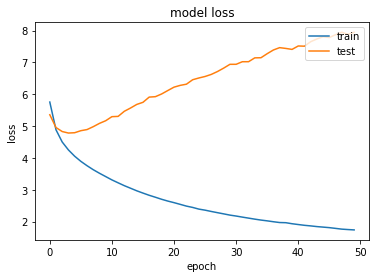

In [19]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [20]:
model.save('amazon_qa_pairs_model.hdf5')

In [21]:
from tensorflow import keras
model = keras.models.load_model('amazon_qa_pairs_model.hdf5')

In [22]:
def generate_greedy_text(seed_text, next_words, model, max_sequence_len):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = tf.keras.preprocessing.sequence.pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predicted = model.predict_classes(token_list, verbose=0)
        
        output_word = ""
        for word,index in tokenizer.word_index.items():
            if index == predicted:
                if word == 'eos':
                    break
                output_word = word
                break
        seed_text += " "+output_word
    return seed_text.title()

In [23]:
def get_next_word_dist(possible_seed_texts, max_sequence_len):
    possible_predictions = []
    for seed_text in possible_seed_texts:
        #print("Seed text - ", seed_text)
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = tf.keras.preprocessing.sequence.pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predicted = model.predict(token_list, verbose=0)[0]
        #print("Predicted - ", predicted[34])
        possible_predictions.append(predicted)
    
    #print(possible_predictions)
    return possible_predictions

In [24]:
eos_token = tokenizer.texts_to_sequences(['eos'])[0]
print(eos_token)

[]


In [25]:
from math import log
def generate_beam_text(seed_text, next_words, model, max_sequence_len, beam_search_n, break_at_eos):
    sequences = [[list(), 0.0]]
    possible_seed_texts = [[seed_text]]
    for _ in range(next_words):
        
        # get word probability distribution
        predicted_distributions = get_next_word_dist(possible_seed_texts, max_sequence_len)
        #print("Len - predicted_distributions ", len(predicted_distributions))
        
        all_candidates = list()
        for i in range(len(sequences)):
            #print("Len", "predicted_distributions", str(len(predicted_distributions[0])))
            for j in range(len(predicted_distributions[i])):
                seq, score = sequences[i]
                
                if predicted_distributions[i][j] > 0:
                    candidate = [seq + [j], score - log(predicted_distributions[i][j])]
                    if break_at_eos and j == eos_token:
                        continue
                    else:
                        all_candidates.append(candidate)

        ordered = sorted(all_candidates, key=lambda tup:tup[1])
        
        sequences = ordered[:beam_search_n]
        
        # clear list and put top beam results
        possible_seed_texts = list()
        for i in range(len(sequences)):
            seq, score = sequences[i]
            sentence = seed_text
            for predicted in seq:
                output_word = None
                for word, index in tokenizer.word_index.items():
                    if index == predicted:
                        if word == 'eos' and break_at_eos:
                            break
                        
                        output_word = word
                        #print(predicted, output_word)
                        break
                if output_word:
                    sentence = sentence + " " + output_word
            
            possible_seed_texts.append(sentence)

            to_print = ' '.join(sentence.replace('eos', '').split())
            print(to_print.replace(seed_text, "", 1), score)
          
          
        print("-----")
    #return seed_text.title()

In [26]:
print(generate_greedy_text("hello", 100, model, max_sequence_len))

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Hello Time It Was Nice Chatting With You Same Here Have A Good One You Too Bye Bye Bye Bye Bye Bye Bye Bye Bye Bye Bye Bye Bye Bye Bye Bye Bye Bye Bye Bye Bye Bye Bye Bye Bye Bye Bye Bye Bye Bye Bye Bye Bye Bye Bye Bye Bye Bye Bye Bye Bye Bye Bye Bye Bye Bye Bye Bye Bye Bye Bye Bye Bye Bye Bye Have A Good Day Bye Bye Bye Take Care Now Have A Good One Have A Good One You Too Bye Have A Good One You Too Bye Bye Bye


In [27]:
print(generate_beam_text("sorry", 10, model, max_sequence_len, 25, False))

 have 1.3801121241370715
 maybe 1.6187195589958645
 i 2.5062736437981368
 it 2.5081924830342106
 take 2.5759738510676997
 good 2.6274456849267676
 bye 2.8081287783644076
 thank 2.8222508204503063
 thanks 3.079151539084256
 enjoy 4.236801568649677
 you 4.392336349993418
 great 4.50911379271251
 no 4.711380471834203
 nice 4.8874172260208395
 it's 5.284855338220239
 see 6.043098893898694
 and 6.109924731218144
 a 6.153473297220455
 my 6.50563087989119
 i'm 6.753487095501529
 well 7.0520786232649915
 now 7.234119821819552
 very 7.723713296208294
 also 8.10504190824694
 some 8.219353106350878
-----
 have a 1.481071687213866
 take care 2.7384948562117293
 good bye 2.9161758381871206
 maybe problem 3.196186290002351
 thank you 3.284569118536511
 bye bye 3.3222637176029446
 it has 3.4404936093016354
 maybe next 3.8067943866714655
 maybe ai 3.8076794200735344
 it was 3.9032631653582963
 it does 4.214172370701505
 i will 4.272740993483629
 have fun 4.282882896191936
 thanks bye 4.400518817381348

In [28]:
print(generate_beam_text("good morning", 10, model, max_sequence_len, 25, False))

 bye 0.8109023141812587
 have 1.961310157686853
 see 2.1550489790301715
 con 2.237124125687218
 thank 3.539522813352972
 take 3.6354700734933614
 enjoy 4.036062838338158
 watch 4.1024711187233525
 thanks 4.210135169827135
 goodbye 4.461254758266002
 i 4.473715468264662
 maybe 4.564739840866302
 nice 4.764414529481112
 i'm 4.815035545634151
 no 4.874079419166452
 don't 5.0987955892602335
 it 5.315037380258226
 my 5.8209807312406765
 good 5.827288361061407
 it's 6.222121008995233
 yeah 6.45503875789626
 hope 6.476278935918551
 yes 6.525251990187349
 well 6.917029137616048
 remember 6.944809698818375
-----
 bye bye 1.9459171229683339
 have a 1.9637409857525554
 see you 2.212353659340195
 con nachos 2.444992104993459
 bye have 2.447711954401417
 bye thanks 2.7288112913673563
 bye good 3.4498252592537173
 thank you 3.545016256831983
 bye it 3.5784816745103503
 take care 3.706838173219038
 bye i 3.708496044861806
 enjoy your 4.057039226082962
 bye thank 4.60758404627537
 bye it's 4.711158754

In [29]:
print(generate_beam_text("hello", 10, model, max_sequence_len, 15, False))

 time 1.5826861270496702
 a 1.6631075603595142
 been 1.7443816718478895
 bye 2.4732271944616615
 fun 2.8541170959220508
 very 2.950749031937652
 not 3.03343841198007
 in 3.2704092654000063
 nice 4.004299801456914
 it 4.2157923317425725
 good 4.292788113631703
 well 4.35020512727974
 talking 4.517462436826762
 cc 4.524124825797114
 night 4.59685390143167
-----
 a great 2.0944214104891463
 time it 2.6172867279134344
 bye bye 2.920379333356107
 been good 3.2062491422155075
 been nice 3.2661780904644635
 time have 3.4122391652343067
 a good 3.482540103494257
 been great 3.7479742670493525
 time bye 3.7776089281807184
 very good 3.8189229642614326
 time you 3.8970356847738885
 been indeed 4.032918871834101
 fun have 4.19881000411027
 nice chatting 4.321492661390592
 not a 4.347116693550214
-----
 time it was 2.672427849626486
 been good talking 3.3240741478731217
 bye bye bye 3.405410492653584
 time have a 3.4301616576822567
 a great chat 3.4517719820959716
 been nice chatting 3.51635022680

In [30]:
print(generate_beam_text("bye", 10, model, max_sequence_len, 15, False))

 bye 0.2545460181240734
 have 2.909043171198909
 goodbye 3.0140789510500925
 take 3.9855164299392167
 see 4.35073169024141
 my 4.415245794981899
 thanks 4.521559557527302
 thank 4.652718382570214
 cheers 4.8248546935616625
 enjoy 5.068140878032966
 now 5.260596129066533
 maybe 5.31538471471605
 i 5.444422523823429
 good 5.50216565722881
 it 5.70461539960922
-----
 bye bye 0.6957958479637926
 bye have 2.8554428059060593
 have a 2.9303942116531343
 bye take 3.101565216474677
 goodbye bye 3.32076528164466
 bye see 3.5689399379598545
 take care 3.9960121441670404
 bye maybe 4.113276279000973
 bye thank 4.132817023041035
 bye now 4.3479869204190305
 see yah 4.412070101398042
 bye will 4.4751957668783096
 bye good 4.612767024931624
 bye cheers 4.650370348637626
 thank you 4.662004796858961
-----
 bye bye bye 1.4866157866294873
 bye bye have 2.59931911315148
 bye bye take 2.691650075239862
 bye bye now 2.8132663626779664
 bye have a 2.867115814699724
 bye take care 3.116629402411148
 have a g

In [31]:
print(generate_beam_text("do you like shakespeare", 10, model, max_sequence_len, 15, False))

 bye 0.8109023141812587
 have 1.961310157686853
 see 2.1550489790301715
 con 2.237124125687218
 thank 3.539522813352972
 take 3.6354700734933614
 enjoy 4.036062838338158
 watch 4.1024711187233525
 thanks 4.210135169827135
 goodbye 4.461254758266002
 i 4.473715468264662
 maybe 4.564739840866302
 nice 4.764414529481112
 i'm 4.815035545634151
 no 4.874079419166452
-----
 bye bye 2.0120234899997103
 have you 2.6772529023615492
 see you 2.75105030372787
 bye have 2.8606524553862345
 have a 2.891501628550543
 bye take 3.199742827913382
 bye will 3.3516707518968674
 bye thanks 3.409957405999525
 thank you 3.565347639975255
 see ya 3.594590449802596
 con i'm 3.667299481079276
 bye haha 4.052337193706128
 bye okay 4.172996064815308
 con i 4.299331809268988
 bye i 4.336061048704039
-----
 bye have a 2.912549457230596
 have you ever 3.0486967470505055
 have a good 3.2675321558973
 bye take care 3.313369905207991
 bye bye bye 3.5726352944712483
 bye bye take 3.645815491870255
 bye bye have 3.71646